In [1]:
# Install Required Libraries
!pip install -q insightface onnxruntime opencv-python-headless

# Imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from insightface.app import FaceAnalysis
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# ArcFace Setup
app = FaceAnalysis(name='buffalo_l')
app.prepare(ctx_id=0, det_size=(160, 160))

# Reference Directory
DEFAULT_REF_DIR = "/content/drive/MyDrive/Comys_Hackathon5/Task_B/val"
TEMP_SAVE_PATH = "/content/denoised_temp.jpg"

# Enhance Non-Noise Distortions
def enhanced_distortion_filters(img, distortion_type=None):
    img = cv2.resize(img, (160, 160))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if distortion_type is None:
        return img

    distortion_type = distortion_type.lower()
    if "foggy" in distortion_type:
        img = cv2.detailEnhance(img, sigma_s=10, sigma_r=0.15)
    elif "sunlight" in distortion_type or "lowlight" in distortion_type:
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.5)
        l = clahe.apply(l)
        img = cv2.cvtColor(cv2.merge((l, a, b)), cv2.COLOR_LAB2RGB)
    elif "blur" in distortion_type:
        img = cv2.GaussianBlur(img, (3, 3), 0)
        img = cv2.detailEnhance(img, sigma_s=5, sigma_r=0.15)
    return img

# Noise/Rain Filter
def denoise_if_needed(image_path, distortion_type):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image not found: {image_path}")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if distortion_type in ['noise', 'rain']:
        denoised = cv2.medianBlur(img_rgb, 5)
        denoised_bgr = cv2.cvtColor(denoised, cv2.COLOR_RGB2BGR)
        cv2.imwrite(TEMP_SAVE_PATH, denoised_bgr)
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(img_rgb)
        plt.title('Original (Distorted)')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(denoised)
        plt.title('Denoised Output')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        return TEMP_SAVE_PATH
    else:
        return image_path

# ArcFace Embedding Extractor
def get_arcface_embedding(img, distortion_type=None):
    img = cv2.resize(img, (160, 160))
    if distortion_type and any(x in distortion_type for x in ["noise", "rain"]):
        img = cv2.medianBlur(img, 5)
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.5)
        l = clahe.apply(l)
        img = cv2.cvtColor(cv2.merge((l, a, b)), cv2.COLOR_LAB2RGB)
    else:
        img = enhanced_distortion_filters(img, distortion_type)

    img_flip = cv2.flip(img, 1)
    faces1 = app.get(img)
    faces2 = app.get(img_flip)

    emb_list = []
    if faces1:
        emb1 = faces1[0].embedding
        emb_list.append(emb1 / np.linalg.norm(emb1))
    if faces2:
        emb2 = faces2[0].embedding
        emb_list.append(emb2 / np.linalg.norm(emb2))
    if not emb_list:
        return None
    return np.mean(emb_list, axis=0)

# Single Image Matching Function (With Label Output)
def test_single_image_arcface():
    distorted_path = input("Enter full path of distorted image: ").strip()
    threshold = 0.5

    filename = os.path.basename(distorted_path)
    distortion_type = next((d for d in ['blur', 'lowlight', 'noise', 'sunlight', 'rain', 'foggy', 'resized']
                            if d in filename.lower()), None)

    final_input_path = denoise_if_needed(distorted_path, distortion_type)
    img = cv2.imread(final_input_path)
    if img is None:
        print(f"Failed to load: {final_input_path}")
        return None, 0, 0

    emb1 = get_arcface_embedding(img, distortion_type)
    if emb1 is None:
        print("No face detected in the input image.")
        return None, 0, 0

    best_score = -1
    best_identity = None

    for identity in sorted(os.listdir(DEFAULT_REF_DIR)):
        ref_folder = os.path.join(DEFAULT_REF_DIR, identity)
        ref_images = glob(os.path.join(ref_folder, "*.jpg"))
        if not ref_images:
            continue

        for ref_path in ref_images:
            ref_img = cv2.imread(ref_path)
            if ref_img is None:
                continue
            ref_faces = app.get(cv2.cvtColor(ref_img, cv2.COLOR_BGR2RGB))
            if not ref_faces:
                continue
            emb2 = ref_faces[0].embedding
            emb2 = emb2 / np.linalg.norm(emb2)
            similarity = np.dot(emb1, emb2)
            if similarity > best_score:
                best_score = similarity
                best_identity = identity

    # Show results
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Input Image")
    plt.axis('off')

    if best_identity:
        ref_img_path = os.path.join(DEFAULT_REF_DIR, best_identity,
                                    os.listdir(os.path.join(DEFAULT_REF_DIR, best_identity))[0])
        ref_img = cv2.imread(ref_img_path)
        ref_img = cv2.cvtColor(ref_img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 2, 2)
        plt.imshow(ref_img)
        plt.title(f"Matched: {best_identity}\nScore: {best_score:.4f}")
        plt.axis('off')
    else:
        plt.subplot(1, 2, 2)
        plt.text(0.5, 0.5, "No Match Found", ha='center', va='center', fontsize=14)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Compute Label based only on similarity threshold)
    label = 1 if best_score >= threshold else 0

    # Display results
    print("\n Ground Truth: (Not used — verification by score only)")
    print(f"Predicted Match: {best_identity}")
    print(f"Cosine Similarity Score: {best_score:.4f}")
    print(f"Verification Label: {label}  → {'Same Person' if label == 1 else 'Different Person'}")

    return best_identity, best_score, label



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 6.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.3 MB/s eta 0:00:00
Mounted at /content/drive
download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:04<00:00, 65672.98KB/s]
/usr/local/lib/python3.11/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (160, 160)


📸 Enter full path of distorted image: /content/drive/MyDrive/Comys_Hackathon5/Task_B/val/Queen_Noor/distortion/Queen_Noor_0001_lowlight.jpg


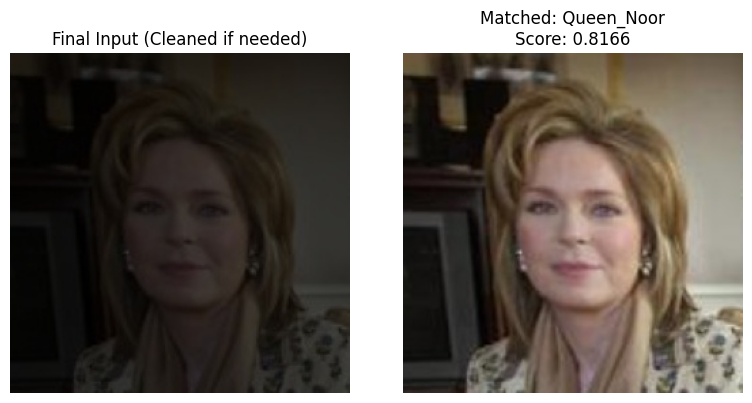

✅ Match: Queen_Noor (Score: 0.8166)


('Queen_Noor', np.float32(0.81655765))

In [ ]:
test_single_image_arcface()

📸 Enter full path of distorted image: /content/drive/MyDrive/mukhesh.webp


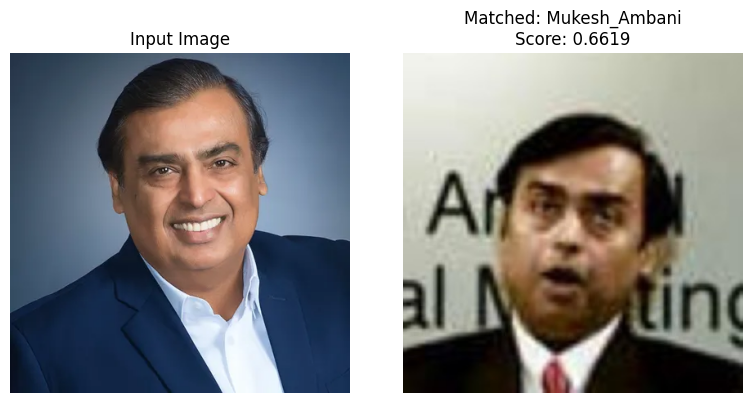


🧾 Ground Truth: (Not used — verification by score only)
✅ Predicted Match: Mukesh_Ambani
🔗 Cosine Similarity Score: 0.6619
🏷️ Verification Label: 1  → Same Person


('Mukesh_Ambani', np.float32(0.66187185), 1)

In [ ]:
test_single_image_arcface()

In [ ]:
from itertools import combinations
import random

def generate_pairs_from_reference(ref_dir=DEFAULT_REF_DIR, max_negative_pairs_per_identity=5):
    identity_folders = sorted([f for f in os.listdir(ref_dir) if os.path.isdir(os.path.join(ref_dir, f))])
    id_to_images = {
        identity: glob(os.path.join(ref_dir, identity, "*.jpg"))
        for identity in identity_folders
    }

    pairs = []

    # Generate positive pairs
    for identity, images in id_to_images.items():
        if len(images) < 2:
            continue  # Not enough for a positive pair
        for img1, img2 in combinations(images, 2):
            pairs.append((img1, img2, 1))

    # Generate negative pairs
    for identity, img_list in id_to_images.items():
        if not img_list:
            continue
        other_identities = [id2 for id2 in identity_folders if id2 != identity and id_to_images[id2]]
        if not other_identities:
            continue
        for _ in range(min(max_negative_pairs_per_identity, len(img_list))):
            img1 = random.choice(img_list)
            neg_id = random.choice(other_identities)
            img2 = random.choice(id_to_images[neg_id])
            pairs.append((img1, img2, 0))

    # Summary
    pos_count = sum(1 for _, _, l in pairs if l == 1)
    neg_count = sum(1 for _, _, l in pairs if l == 0)
    print(f"Total pairs: {len(pairs)} | Positive: {pos_count} | Negative: {neg_count}")

    return pairs


In [ ]:
pairs = generate_pairs_from_reference()

✅ Total pairs: 844 | Positive: 523 | Negative: 321


In [ ]:
negative_pairs = [pair for pair in pairs if pair[2] == 0]
print(f"Total Negative Pairs: {len(negative_pairs)}")


❌ Total Negative Pairs: 321


In [ ]:
def show_negative_pairs(pairs, num_to_show=5):
    negative_pairs = [pair for pair in pairs if pair[2] == 0]
    for i, (img1_path, img2_path, _) in enumerate(negative_pairs[:num_to_show]):
        img1 = cv2.imread(img1_path)
        img2 = cv2.imread(img2_path)

        if img1 is None or img2 is None:
            print(f"Could not load image pair: {img1_path}, {img2_path}")
            continue

        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(img1)
        plt.title("Image 1")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(img2)
        plt.title("Image 2")
        plt.axis('off')

        plt.suptitle(f"Negative Pair (Label=0) #{i+1}", fontsize=16)
        plt.tight_layout()
        plt.show()


In [ ]:
show_negative_pairs(pairs, num_to_show=7)  # You can change the number to 10 or more


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def show_positive_pairs(pairs, num_to_show=5):
    positive_pairs = [pair for pair in pairs if pair[2] == 1]
    for i, (img1_path, img2_path, _) in enumerate(positive_pairs[:num_to_show]):
        img1 = cv2.imread(img1_path)
        img2 = cv2.imread(img2_path)

        if img1 is None or img2 is None:
            print(f"Could not load image pair: {img1_path}, {img2_path}")
            continue

        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(img1)
        plt.title("Image 1")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(img2)
        plt.title("Image 2")
        plt.axis('off')

        plt.suptitle(f"Positive Pair (Label 1) #{i+1}", fontsize=16)
        plt.tight_layout()
        plt.show()


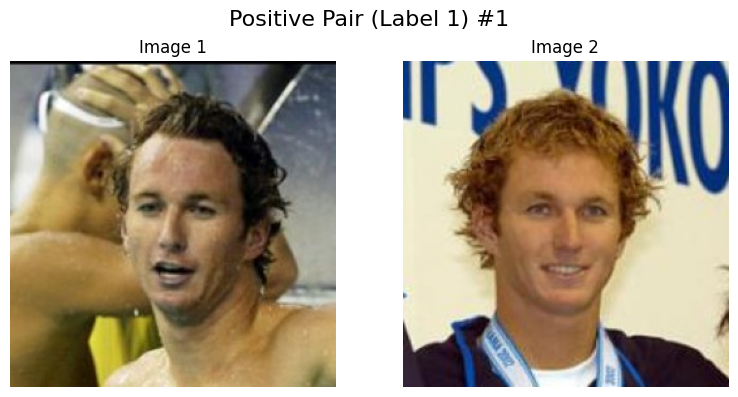

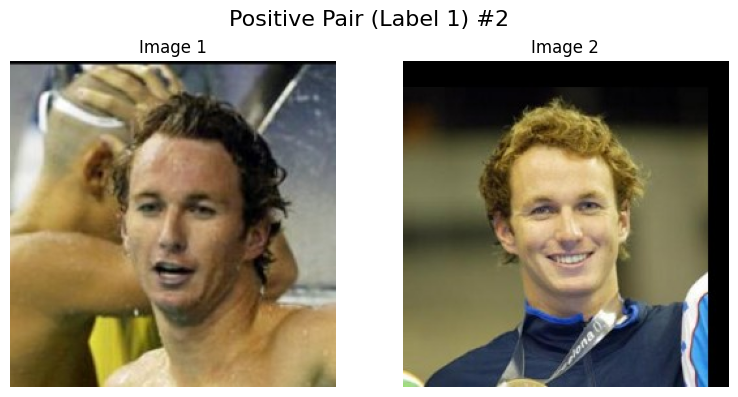

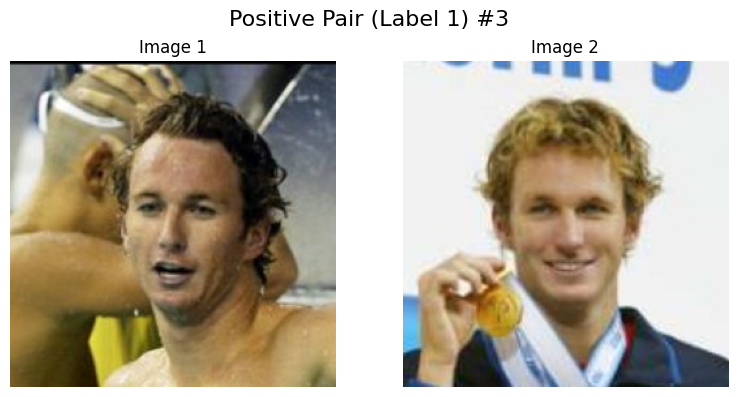

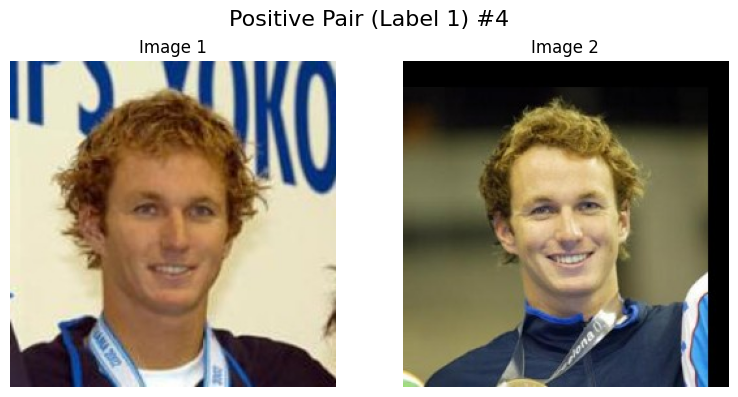

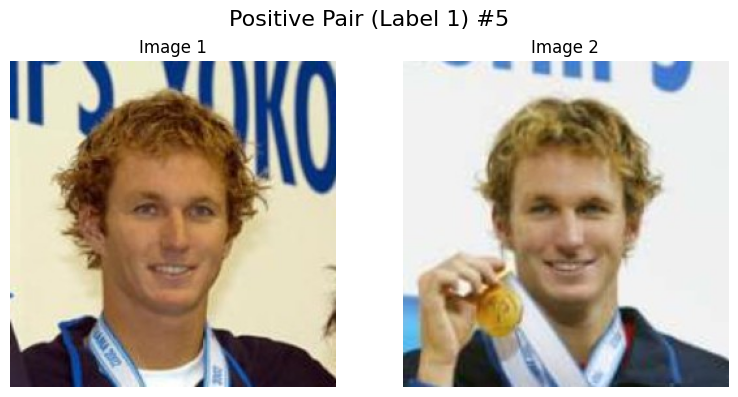

In [ ]:
show_positive_pairs(pairs, num_to_show=5)



In [ ]:
def cache_reference_embeddings():
    ref_embeddings = {}
    for identity in sorted(os.listdir(DEFAULT_REF_DIR)):
        ref_folder = os.path.join(DEFAULT_REF_DIR, identity)
        ref_images = glob(os.path.join(ref_folder, "*.jpg"))
        emb_list = []
        for ref_path in ref_images:
            ref_img = cv2.imread(ref_path)
            if ref_img is None:
                continue
            ref_faces = app.get(cv2.cvtColor(ref_img, cv2.COLOR_BGR2RGB))
            if not ref_faces:
                continue
            emb = ref_faces[0].embedding
            emb = emb / np.linalg.norm(emb)
            emb_list.append(emb)
        if emb_list:
            ref_embeddings[identity] = emb_list
    return ref_embeddings


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

def batch_arcface_identity_match(test_root_dir, ref_dir=DEFAULT_REF_DIR, threshold=0.5):
    all_preds = []
    all_labels = []
    all_scores = []

    print("Starting batch evaluation...")

    for identity in tqdm(sorted(os.listdir(test_root_dir))):
        identity_path = os.path.join(test_root_dir, identity)
        if not os.path.isdir(identity_path):
            continue

        for distortion in os.listdir(identity_path):
            distortion_folder = os.path.join(identity_path, distortion)
            if not os.path.isdir(distortion_folder):
                continue

            for img_name in os.listdir(distortion_folder):
                img_path = os.path.join(distortion_folder, img_name)
                distortion_type = distortion.lower()

                final_input_path = denoise_if_needed(img_path, distortion_type)
                img = cv2.imread(final_input_path)
                if img is None:
                    continue

                emb1 = get_arcface_embedding(img, distortion_type)
                if emb1 is None:
                    continue

                # Match to reference embeddings
                best_score = -1
                best_identity = None

                for ref_id in sorted(os.listdir(ref_dir)):
                    ref_folder = os.path.join(ref_dir, ref_id)
                    ref_imgs = glob(os.path.join(ref_folder, "*.jpg"))
                    for ref_img_path in ref_imgs:
                        ref_img = cv2.imread(ref_img_path)
                        if ref_img is None:
                            continue
                        ref_faces = app.get(cv2.cvtColor(ref_img, cv2.COLOR_BGR2RGB))
                        if not ref_faces:
                            continue
                        emb2 = ref_faces[0].embedding
                        emb2 = emb2 / np.linalg.norm(emb2)
                        similarity = np.dot(emb1, emb2)
                        if similarity > best_score:
                            best_score = similarity
                            best_identity = ref_id

                true_label = identity
                predicted_label = best_identity
                score = best_score

                all_labels.append(true_label)
                all_preds.append(predicted_label)
                all_scores.append(score)

                print(f"{img_name} | GT: {true_label} | Pred: {predicted_label} | Score: {score:.4f}")

    # Top-1 Accuracy
    top1_acc = accuracy_score(all_labels, all_preds)

    # Macro F1
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    print(f"\nTop-1 Accuracy: {top1_acc:.4f}")
    print(f"Macro-averaged F1-score: {f1_macro:.4f}")
    print(f"Total Samples Evaluated: {len(all_labels)}")

    return {
        'predictions': all_preds,
        'ground_truth': all_labels,
        'scores': all_scores,
        'top1_accuracy': top1_acc,
        'f1_macro': f1_macro
    }


In [ ]:
test_dir = "/content/drive/MyDrive/Comys_Hackathon5/Task_B/test"
results = batch_arcface_identity_match(test_dir)


🚀 Starting batch evaluation...


  0%|          | 0/5 [00:00<?, ?it/s]

🖼️ Gabi_Zimmer_0001_resized.jpg | GT: Gabi_Zimmer | Pred: Gabi_Zimmer | Score: 0.9581
🖼️ Gabi_Zimmer_0001_lowlight.jpg | GT: Gabi_Zimmer | Pred: Gabi_Zimmer | Score: 0.9519
🖼️ Gabi_Zimmer_0001_blurred.jpg | GT: Gabi_Zimmer | Pred: Gabi_Zimmer | Score: 0.7980
🖼️ Gabi_Zimmer_0001_rainy.jpg | GT: Gabi_Zimmer | Pred: Gabi_Zimmer | Score: 0.6293
🖼️ Gabi_Zimmer_0001_foggy.jpg | GT: Gabi_Zimmer | Pred: Gabi_Zimmer | Score: 0.9369


 20%|██        | 1/5 [18:33<1:14:15, 1113.86s/it]

🖼️ Gabi_Zimmer_0001_noisy.jpg | GT: Gabi_Zimmer | Pred: Gabi_Zimmer | Score: 0.5546
🖼️ Garry_Kasparov_0001_lowlight.jpg | GT: Garry_Kasparov | Pred: Garry_Kasparov | Score: 0.9393
🖼️ Garry_Kasparov_0001_sunny.jpg | GT: Garry_Kasparov | Pred: Chris_Columbus | Score: 0.1249
🖼️ Garry_Kasparov_0002_rainy.jpg | GT: Garry_Kasparov | Pred: Garry_Kasparov | Score: 0.6464
🖼️ Garry_Kasparov_0001_foggy.jpg | GT: Garry_Kasparov | Pred: Garry_Kasparov | Score: 0.8642
🖼️ Garry_Kasparov_0002_lowlight.jpg | GT: Garry_Kasparov | Pred: Garry_Kasparov | Score: 0.9442
🖼️ Garry_Kasparov_0002_resized.jpg | GT: Garry_Kasparov | Pred: Garry_Kasparov | Score: 0.9353
🖼️ Garry_Kasparov_0001_rainy.jpg | GT: Garry_Kasparov | Pred: Garry_Kasparov | Score: 0.5443
🖼️ Garry_Kasparov_0002_blurred.jpg | GT: Garry_Kasparov | Pred: Garry_Kasparov | Score: 0.7497
🖼️ Garry_Kasparov_0001_resized.jpg | GT: Garry_Kasparov | Pred: Garry_Kasparov | Score: 0.9578
🖼️ Garry_Kasparov_0002_noisy.jpg | GT: Garry_Kasparov | Pred: Garry

 40%|████      | 2/5 [57:19<1:31:20, 1826.86s/it]

🖼️ Garry_Kasparov_0001_blurred.jpg | GT: Garry_Kasparov | Pred: Garry_Kasparov | Score: 0.7731
🖼️ Gary_Bettman_0001_resized.jpg | GT: Gary_Bettman | Pred: Gary_Bettman | Score: 0.9660
🖼️ Gary_Bettman_0001_noisy.jpg | GT: Gary_Bettman | Pred: Gary_Bettman | Score: 0.7085
🖼️ Gary_Bettman_0001_foggy.jpg | GT: Gary_Bettman | Pred: Gary_Bettman | Score: 0.8641
🖼️ Gary_Bettman_0001_lowlight.jpg | GT: Gary_Bettman | Pred: Gary_Bettman | Score: 0.9541
🖼️ Gary_Bettman_0001_rainy.jpg | GT: Gary_Bettman | Pred: Gary_Bettman | Score: 0.5696


 60%|██████    | 3/5 [1:14:57<49:11, 1475.79s/it]

🖼️ Gary_Bettman_0001_blurred.jpg | GT: Gary_Bettman | Pred: Gary_Bettman | Score: 0.8435
🖼️ Gene_Autry_0001_lowlight.jpg | GT: Gene_Autry | Pred: Gene_Autry | Score: 0.9536
🖼️ Gene_Autry_0001_resized.jpg | GT: Gene_Autry | Pred: Gene_Autry | Score: 0.9634
🖼️ Gene_Autry_0001_rainy.jpg | GT: Gene_Autry | Pred: Gene_Autry | Score: 0.5069
🖼️ Gene_Autry_0001_blurred.jpg | GT: Gene_Autry | Pred: Gene_Autry | Score: 0.8151
🖼️ Gene_Autry_0001_noisy.jpg | GT: Gene_Autry | Pred: Gene_Autry | Score: 0.6377


 80%|████████  | 4/5 [1:32:37<21:51, 1311.54s/it]

🖼️ Gene_Autry_0001_foggy.jpg | GT: Gene_Autry | Pred: Gene_Autry | Score: 0.8869
🖼️ George_Blaney_0001_noisy.jpg | GT: George_Blaney | Pred: George_Blaney | Score: 0.5801
🖼️ George_Blaney_0001_resized.jpg | GT: George_Blaney | Pred: George_Blaney | Score: 0.9654
🖼️ George_Blaney_0001_rainy.jpg | GT: George_Blaney | Pred: George_Blaney | Score: 0.6643
🖼️ George_Blaney_0001_foggy.jpg | GT: George_Blaney | Pred: George_Blaney | Score: 0.8459
🖼️ George_Blaney_0001_lowlight.jpg | GT: George_Blaney | Pred: George_Blaney | Score: 0.9468


100%|██████████| 5/5 [1:50:21<00:00, 1324.32s/it]

🖼️ George_Blaney_0001_blurred.jpg | GT: George_Blaney | Pred: George_Blaney | Score: 0.8286

🎯 Top-1 Accuracy: 0.9730
📊 Macro-averaged F1-score: 0.8267
🧮 Total Samples Evaluated: 37


In [2]:
def verify_identity_pair(ref_img_path, test_img_path, distortion_type=None, threshold=0.5):

    # Load reference image
    ref_img = cv2.imread(ref_img_path)
    if ref_img is None:
        print(f"Could not load reference image: {ref_img_path}")
        return

    # Load test image (may be distorted)
    final_input_path = denoise_if_needed(test_img_path, distortion_type)
    test_img = cv2.imread(final_input_path)
    if test_img is None:
        print(f"Could not load test image: {test_img_path}")
        return

    # Get embeddings
    ref_emb = get_arcface_embedding(ref_img)
    test_emb = get_arcface_embedding(test_img, distortion_type)

    if ref_emb is None or test_emb is None:
        print("Face not detected in one of the images.")
        return

    # Cosine similarity
    similarity = np.dot(ref_emb, test_emb)
    match = similarity >= threshold

    # Display results
    print(f"Cosine Similarity Score: {similarity:.4f}")
    print("Result:" if match else "Result:", "Same Person" if match else "Different Person")

    # Show side-by-side
    ref_rgb = cv2.cvtColor(ref_img, cv2.COLOR_BGR2RGB)
    test_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(ref_rgb)
    plt.title("Reference Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(test_rgb)
    plt.title("Test Image")
    plt.axis('off')

    plt.suptitle(f"{'Match' if match else 'No Match'} | Score: {similarity:.4f}", fontsize=14)
    plt.tight_layout()
    plt.show()

    return match, similarity


🔗 Cosine Similarity Score: 0.7744
✅ Result: Same Person


/tmp/ipython-input-13-4096380062.py:50: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


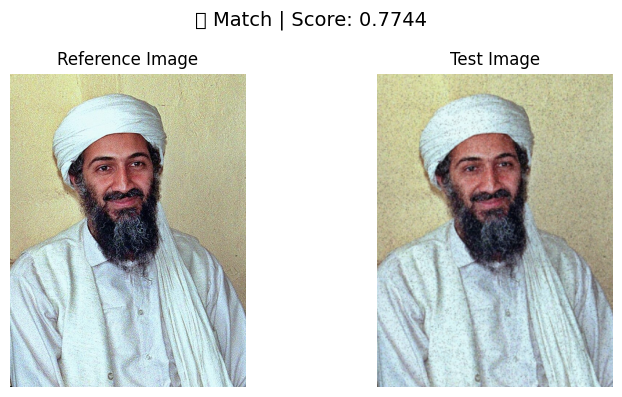

(np.True_, np.float32(0.7744249))

In [ ]:
verify_identity_pair(
    ref_img_path="/content/laden1.jpg",
    test_img_path="/content/laden2.png",
    distortion_type="blur",
    threshold=0.5
)


Cosine Similarity Score: -0.0002
Result: Different Person


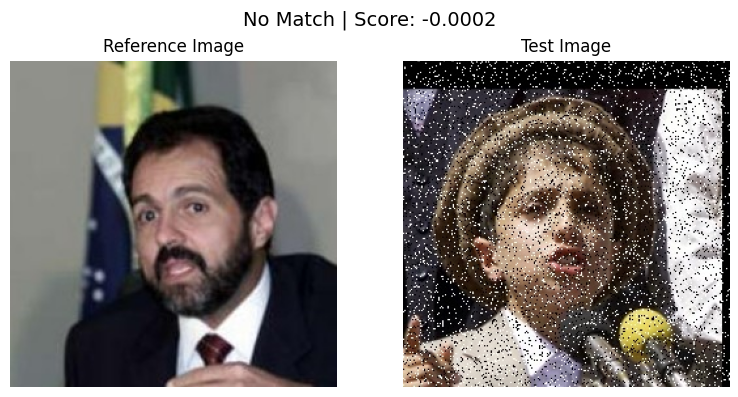

(np.False_, np.float32(-0.00021167472))

In [6]:
verify_identity_pair(
    ref_img_path="/content/drive/MyDrive/Comys_Hackathon5/Task_B/train/Agnelo_Queiroz/Agnelo_Queiroz_0001.jpg",
    test_img_path="/content/drive/MyDrive/Comys_Hackathon5/Task_B/train/Ahmad_Masood/distortion/Ahmad_Masood_0001_noisy.jpg",
    distortion_type="blur",
    threshold=0.5
)
